In [1]:
"""
Medical Image Classifier with Grad-CAM Explainability
Classify images and visualize model interpretability using Grad-CAM
"""

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All imports successful!")
print(f"TensorFlow version: {tf.__version__}")

All imports successful!
TensorFlow version: 2.19.0


In [22]:
# Configuration Parameters
CONFIG = {
    # Data
    'IMG_SIZE': 192,
    'BATCH_SIZE': 32,
    'TRAIN_SAMPLES': 6000,
    'TEST_SAMPLES': 1000,
    'NUM_CLASSES': 10,

    # Training
    'EPOCHS': 12,
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.3,

    # Augmentation
    'ROTATION_RANGE': 15,
    'WIDTH_SHIFT_RANGE': 0.1,
    'HEIGHT_SHIFT_RANGE': 0.1,
    'ZOOM_RANGE': 0.15,

    # Output paths
    'MODEL_PATH': 'classifier_model.h5',
    'GRADCAM_PATH': 'grad_cam_visualizations.png',
    'HISTORY_PATH': 'training_history.png'
}

print("📋 Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

📋 Configuration:
  IMG_SIZE: 192
  BATCH_SIZE: 32
  TRAIN_SAMPLES: 6000
  TEST_SAMPLES: 1000
  NUM_CLASSES: 10
  EPOCHS: 12
  LEARNING_RATE: 0.001
  DROPOUT_RATE: 0.3
  ROTATION_RANGE: 15
  WIDTH_SHIFT_RANGE: 0.1
  HEIGHT_SHIFT_RANGE: 0.1
  ZOOM_RANGE: 0.15
  MODEL_PATH: classifier_model.h5
  GRADCAM_PATH: grad_cam_visualizations.png
  HISTORY_PATH: training_history.png


In [3]:
def load_cifar10_data(img_size=192, train_samples=6000, test_samples=1000):
    """
    Load and preprocess CIFAR-10 dataset

    Args:
        img_size (int): Target image size (square)
        train_samples (int): Number of training samples to use
        test_samples (int): Number of test samples to use

    Returns:
        tuple: ((x_train, y_train), (x_test, y_test))
    """
    print("Loading CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # Use subset
    x_train = x_train[:train_samples]
    y_train = y_train[:train_samples]
    x_test = x_test[:test_samples]
    y_test = y_test[:test_samples]

    print(f"Resizing images to {img_size}x{img_size}...")
    x_train = tf.image.resize(x_train, (img_size, img_size)) / 255.0
    x_test = tf.image.resize(x_test, (img_size, img_size)) / 255.0

    # Convert labels to categorical
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    print(f"Data loaded: {len(x_train)} training, {len(x_test)} test")
    return (x_train, y_train), (x_test, y_test)


def create_data_augmentation(x_train, y_train, batch_size=32,
                            rotation_range=15, width_shift_range=0.1,
                            height_shift_range=0.1, zoom_range=0.15):
    """
    Create data augmentation generator

    Args:
        x_train, y_train: Training data
        batch_size (int): Batch size
        rotation_range, width_shift_range, etc.: Augmentation parameters

    Returns:
        ImageDataGenerator.flow object
    """
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        horizontal_flip=True,
        zoom_range=zoom_range
    )
    return datagen.flow(x_train, y_train, batch_size=batch_size)

print("Data loading functions defined!")

Data loading functions defined!


In [4]:
# Clear GPU memory
tf.keras.backend.clear_session()

print("\n" + "="*60)
print("STEP 1: LOADING DATA")
print("="*60)

(x_train, y_train), (x_test, y_test) = load_cifar10_data(
    img_size=CONFIG['IMG_SIZE'],
    train_samples=CONFIG['TRAIN_SAMPLES'],
    test_samples=CONFIG['TEST_SAMPLES']
)

print(f"\nData shapes:")
print(f"  x_train: {x_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  x_test: {x_test.shape}")
print(f"  y_test: {y_test.shape}")


STEP 1: LOADING DATA
Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Resizing images to 192x192...
Data loaded: 6000 training, 1000 test

Data shapes:
  x_train: (6000, 192, 192, 3)
  y_train: (6000, 10)
  x_test: (1000, 192, 192, 3)
  y_test: (1000, 10)


In [5]:
def build_model(img_size=192, num_classes=10):
    """
    Build transfer learning model using MobileNetV2

    Args:
        img_size (int): Input image size
        num_classes (int): Number of output classes

    Returns:
        keras.Model: Compiled model
    """
    # Load pre-trained MobileNetV2
    base_model = keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Build full model
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def get_callbacks():
    """Get training callbacks"""
    return [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]

print("Model functions defined!")

Model functions defined!


In [6]:
print("\n" + "="*60)
print("STEP 2: BUILDING MODEL")
print("="*60 + "\n")

model = build_model(img_size=CONFIG['IMG_SIZE'], num_classes=CONFIG['NUM_CLASSES'])
print(f"Model parameters: {model.count_params():,}")
print(f"\nModel Summary:")
model.summary()


STEP 2: BUILDING MODEL

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model parameters: 2,620,106

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_192            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,106 (9.99 MB)

 Trainable params: 362,122 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
def train_model(model, train_gen, x_test, y_test, epochs=12):
    """
    Train the model

    Args:
        model: keras Model
        train_gen: Training data generator
        x_test, y_test: Validation data
        epochs (int): Number of epochs

    Returns:
        keras.callbacks.History
    """
    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=(x_test, y_test),
        epochs=epochs,
        verbose=1,
        callbacks=get_callbacks()
    )
    return history

print("Training functions defined!")

Training functions defined!


In [8]:
print("\n" + "="*60)
print("STEP 3: TRAINING MODEL")
print("="*60 + "\n")

# Create data augmentation
train_gen = create_data_augmentation(
    x_train, y_train,
    batch_size=CONFIG['BATCH_SIZE'],
    rotation_range=CONFIG['ROTATION_RANGE'],
    width_shift_range=CONFIG['WIDTH_SHIFT_RANGE'],
    height_shift_range=CONFIG['HEIGHT_SHIFT_RANGE'],
    zoom_range=CONFIG['ZOOM_RANGE']
)

# Train model
history = train_model(
    model, train_gen, x_test, y_test,
    epochs=CONFIG['EPOCHS']
)

print("\nTraining complete!")


STEP 3: TRAINING MODEL

Epoch 1/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.3986 - loss: 1.7216 - val_accuracy: 0.7180 - val_loss: 0.8280 - learning_rate: 0.0010
Epoch 2/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.6257 - loss: 1.0562 - val_accuracy: 0.7200 - val_loss: 0.7716 - learning_rate: 0.0010
Epoch 3/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.6720 - loss: 0.9430 - val_accuracy: 0.7350 - val_loss: 0.7617 - learning_rate: 0.0010
Epoch 4/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.7106 - loss: 0.8664 - val_accuracy: 0.7520 - val_loss: 0.7254 - learning_rate: 0.0010
Epoch 5/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.7192 - loss: 0.8171 - val_accuracy: 0.7330 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 6/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7227 - loss: 0.8120 - val_accuracy: 0.7600 - val_loss: 0.7077 - learning_rate: 0.0010
Epoch 7/12
188/188 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - ac

In [9]:
def evaluate_model(model, x_test, y_test):
    """
    Evaluate model on test set

    Args:
        model: keras Model
        x_test, y_test: Test data
    """
    print("\n" + "="*60)
    print("STEP 4: EVALUATION")
    print("="*60 + "\n")

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"✨ Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification report
    y_pred = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\n🔍 Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes,
                              target_names=[f"Class {i}" for i in range(10)]))

    return y_pred

print("Evaluation functions defined!")

Evaluation functions defined!


In [10]:
y_pred = evaluate_model(model, x_test, y_test)


STEP 4: EVALUATION

✨ Test Accuracy: 0.7630 (76.30%)
Test Loss: 0.6873

🔍 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.81      0.78       103
     Class 1       0.79      0.89      0.84        89
     Class 2       0.74      0.67      0.70       100
     Class 3       0.77      0.47      0.58       103
     Class 4       0.63      0.77      0.69        90
     Class 5       0.61      0.72      0.66        86
     Class 6       0.82      0.83      0.82       112
     Class 7       0.82      0.78      0.80       102
     Class 8       0.86      0.83      0.85       106
     Class 9       0.84      0.86      0.85       109

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



In [19]:
def generate_gradcam(model, img_array):
    """
    Generate Grad-CAM heatmap for an image

    Args:
        model: keras Model
        img_array: Input image (1, H, W, 3)

    Returns:
        np.array: Heatmap (H, W) normalized to [0, 1]
    """
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor, training=False)
        pred_class = tf.argmax(predictions[0])
        class_score = predictions[:, pred_class]

    # Compute gradients
    grads = tape.gradient(class_score, img_tensor)
    grads = grads[0].numpy()

    # Convert to grayscale heatmap
    heatmap = np.mean(np.abs(grads), axis=2)
    heatmap = np.maximum(heatmap, 0)

    # Normalize
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    return heatmap


def visualize_predictions(model, x_test, y_test, num_samples=4):
    """
    Visualize predictions with Grad-CAM heatmaps

    Args:
        model: keras Model
        x_test, y_test: Test data
        num_samples (int): Number of samples to visualize
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for idx, i in enumerate(indices):
        img = x_test[i:i+1]
        pred = model.predict(img, verbose=0)
        pred_class = np.argmax(pred)
        confidence = np.max(pred)
        true_class = np.argmax(y_test[i])

        # Generate heatmap
        heatmap = generate_gradcam(model, img)
        heatmap_resized = cv2.resize(heatmap, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))

        # Original image
        axes[idx, 0].imshow(img[0])
        axes[idx, 0].set_title(f'Original\nTrue: {true_class}', fontsize=10, fontweight='bold')
        axes[idx, 0].axis('off')

        # Heatmap
        axes[idx, 1].imshow(heatmap_resized, cmap='hot')
        axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=10, fontweight='bold')
        axes[idx, 1].axis('off')

        # Overlay
        axes[idx, 2].imshow(img[0])
        axes[idx, 2].imshow(heatmap_resized, cmap='hot', alpha=0.4)
        axes[idx, 2].set_title(f'Pred: {pred_class}\nConf: {confidence:.1%}', fontsize=10, fontweight='bold')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(CONFIG['GRADCAM_PATH'], dpi=200, bbox_inches='tight')
    print(f"Visualizations saved to '{CONFIG['GRADCAM_PATH']}'")
    plt.show()

print("Grad-CAM functions defined!")

Grad-CAM functions defined!



STEP 5: GRAD-CAM VISUALIZATIONS

Visualizations saved to 'grad_cam_visualizations.png'


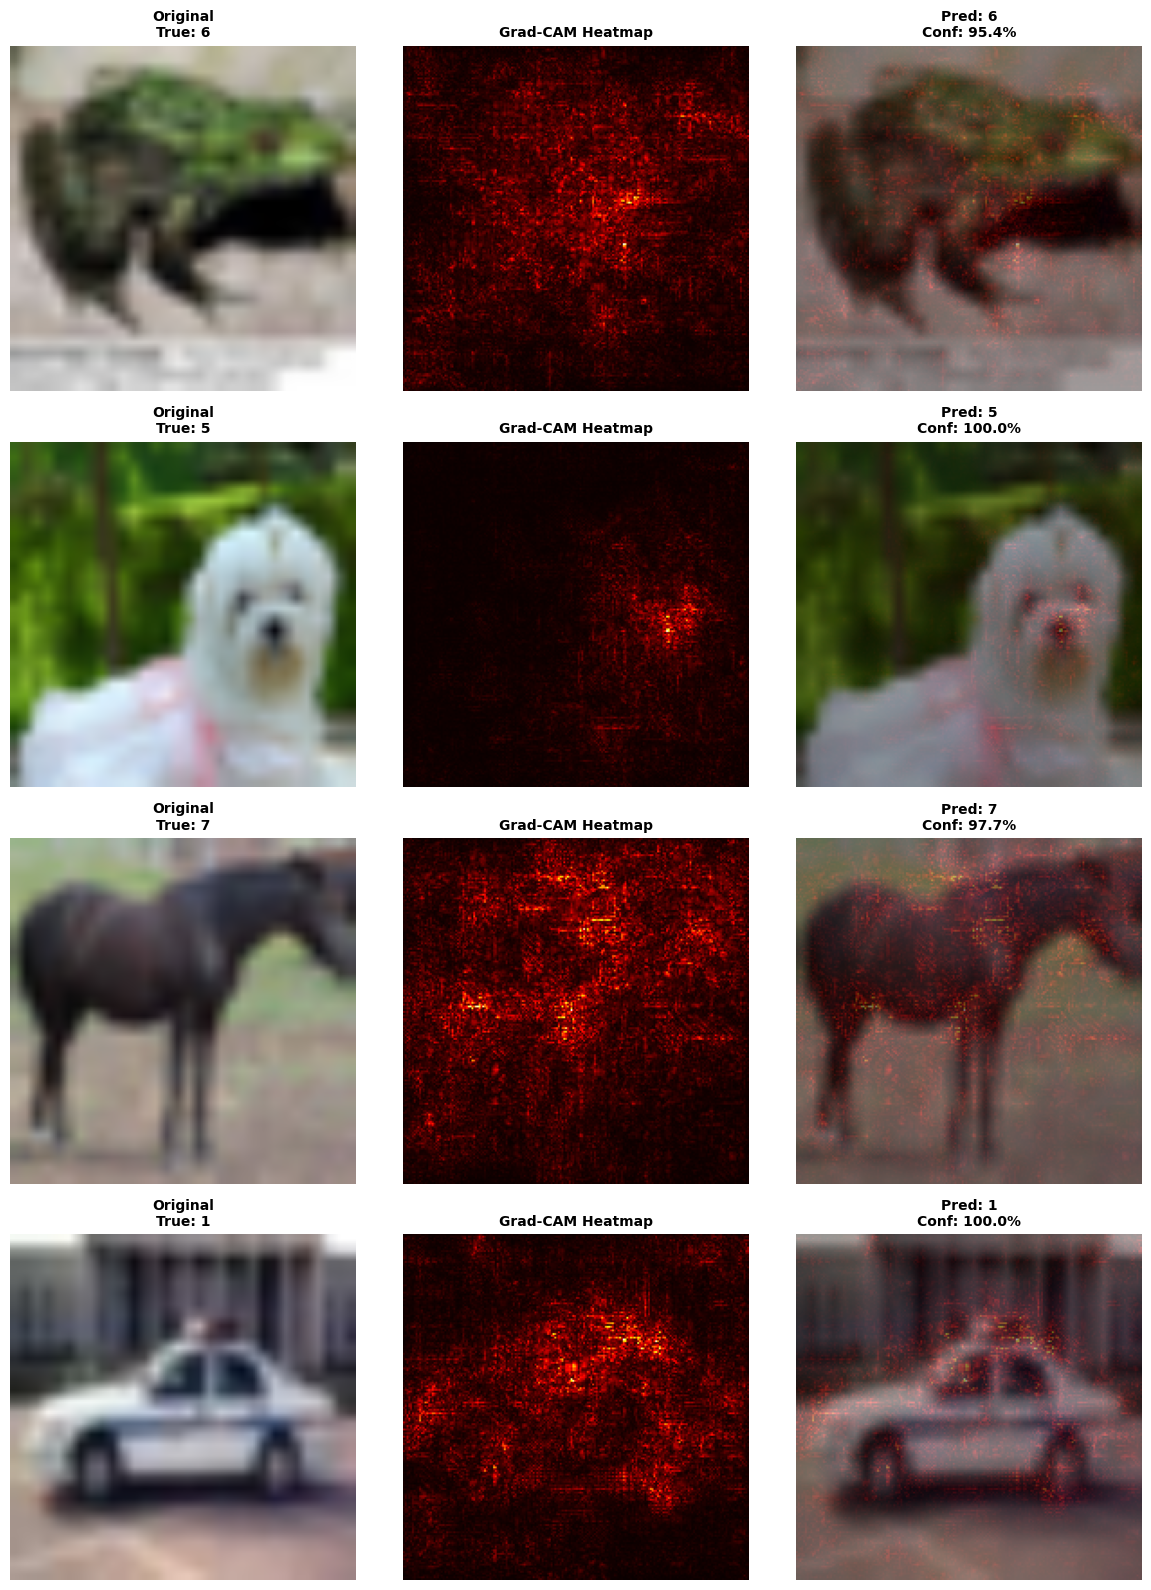

In [20]:
print("\n" + "="*60)
print("STEP 5: GRAD-CAM VISUALIZATIONS")
print("="*60 + "\n")

visualize_predictions(model, x_test, y_test, num_samples=4)

In [13]:
def plot_training_history(history):
    """
    Plot training history

    Args:
        history: keras History object
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy Over Training', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss Over Training', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(CONFIG['HISTORY_PATH'], dpi=200, bbox_inches='tight')
    print(f"Training history saved to '{CONFIG['HISTORY_PATH']}'")
    plt.show()

print("Plotting functions defined!")

Plotting functions defined!



STEP 6: TRAINING HISTORY PLOT

Training history saved to 'training_history.png'


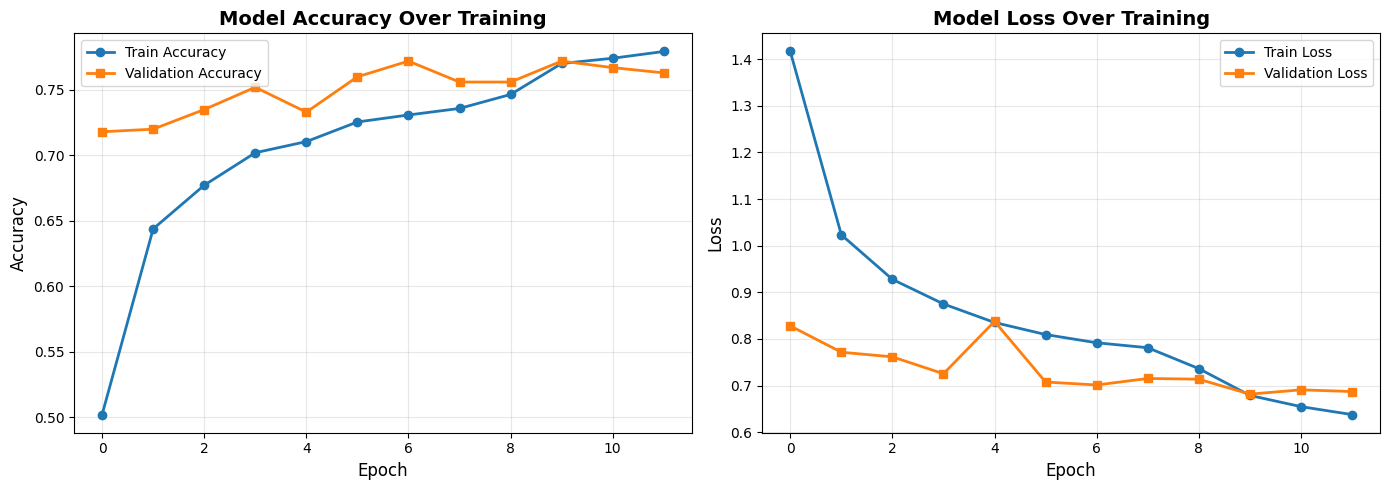

In [14]:
print("\n" + "="*60)
print("STEP 6: TRAINING HISTORY PLOT")
print("="*60 + "\n")

plot_training_history(history)

In [23]:
print("\n" + "="*60)
print("STEP 7: SAVING MODEL")
print("="*60 + "\n")

model.save(CONFIG['MODEL_PATH'])
print(f"Model saved to '{CONFIG['MODEL_PATH']}'")


STEP 7: SAVING MODEL

Model saved to 'classifier_model.h5'
